<a href="https://colab.research.google.com/github/Prajwal011/LLM-s/blob/main/LLM_workshop_projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q -U langchain langchain_community transformers langchain-openai \
langchain-huggingface streamlit pyngrok unstructured tiktoken huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

#Link sage

In [ ]:
%%writefile linksage.py
import os
import streamlit as st
import pickle
import time
from langchain import OpenAI
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredURLLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from transformers import pipeline
from langchain_huggingface.llms import HuggingFacePipeline

from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import HuggingFaceEndpoint
from langchain.chains import RetrievalQA
import textwrap

st.title("LinkSage 🔎")
st.sidebar.title("URLs")

urls = []
for i in range(3):
    url = st.sidebar.text_input(f"URL {i+1}")
    urls.append(url)

process_url_clicked = st.sidebar.button("Process URLs")

file_path = "faiss_store_openai.pkl"

main_placeholder = st.empty()

#### using langchain models

repo_id = 'mistralai/Mistral-7B-Instruct-v0.3'

os.environ["HUGGINGFACEHUB_API_TOKEN"] = 'hf_api'

HUGGINGFACEHUB_API_TOKEN = 'hf_api'

llm = HuggingFaceEndpoint(
    repo_id=repo_id, temperature=0.5, token=HUGGINGFACEHUB_API_TOKEN,
)

##### using huggingaface pipeline

## llm = pipeline("question-answering", model="mistralai/Mistral-7B-Instruct-v0.3")

## llm = HuggingFacePipeline(pipeline=llm)

if process_url_clicked:
    # load data
    loader = UnstructuredURLLoader(urls=urls)
    main_placeholder.text("Data Loading...Started...✅✅✅")
    data = loader.load()
    # split data
    text_splitter = RecursiveCharacterTextSplitter(
        separators=['\n\n', '\n', '.', ','],
        chunk_size=1000
    )
    main_placeholder.text("Text Splitter...Started...✅✅✅")
    docs = text_splitter.split_documents(data)
    # create embeddings and save it to FAISS index
    embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore_openai = FAISS.from_documents(docs, embeddings)
    main_placeholder.text("Embedding Vector Started Building...✅✅✅")
    time.sleep(1)

    # Save the FAISS index to a pickle file
    with open(file_path, "wb") as f:
        pickle.dump(vectorstore_openai, f)

query = main_placeholder.text_input("Question: ")
if query:
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            vectorstore = pickle.load(f)
            chain = RetrievalQAWithSourcesChain.from_llm(llm=llm, retriever=vectorstore.as_retriever())
            result = chain({"question": query}, return_only_outputs=True)
            # result will be a dictionary of this format --> {"answer": "", "sources": [] }
            st.header("Answer")
            st.write(result["answer"])

            # Display sources, if available
            sources = result.get("sources", "")
            if sources:
                st.subheader("Sources:")
                sources_list = sources.split("\n")  # Split the sources by newline
                for source in sources_list:
                    st.write(source)

Writing linksage.py


In [ ]:
from pyngrok import ngrok

# Set authentication token if you haven't already done so
ngrok.set_auth_token('ng_key')

# Start Streamlit server on a specific port
!nohup streamlit run linksage.py --server.port 5011 &

# Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5011', proto='http', bind_tls=True)

# Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

nohup: appending output to 'nohup.out'
nohup: failed to run command 'streamlit': No such file or directory
 * Tunnel URL: https://fe4d-34-16-226-113.ngrok-free.app


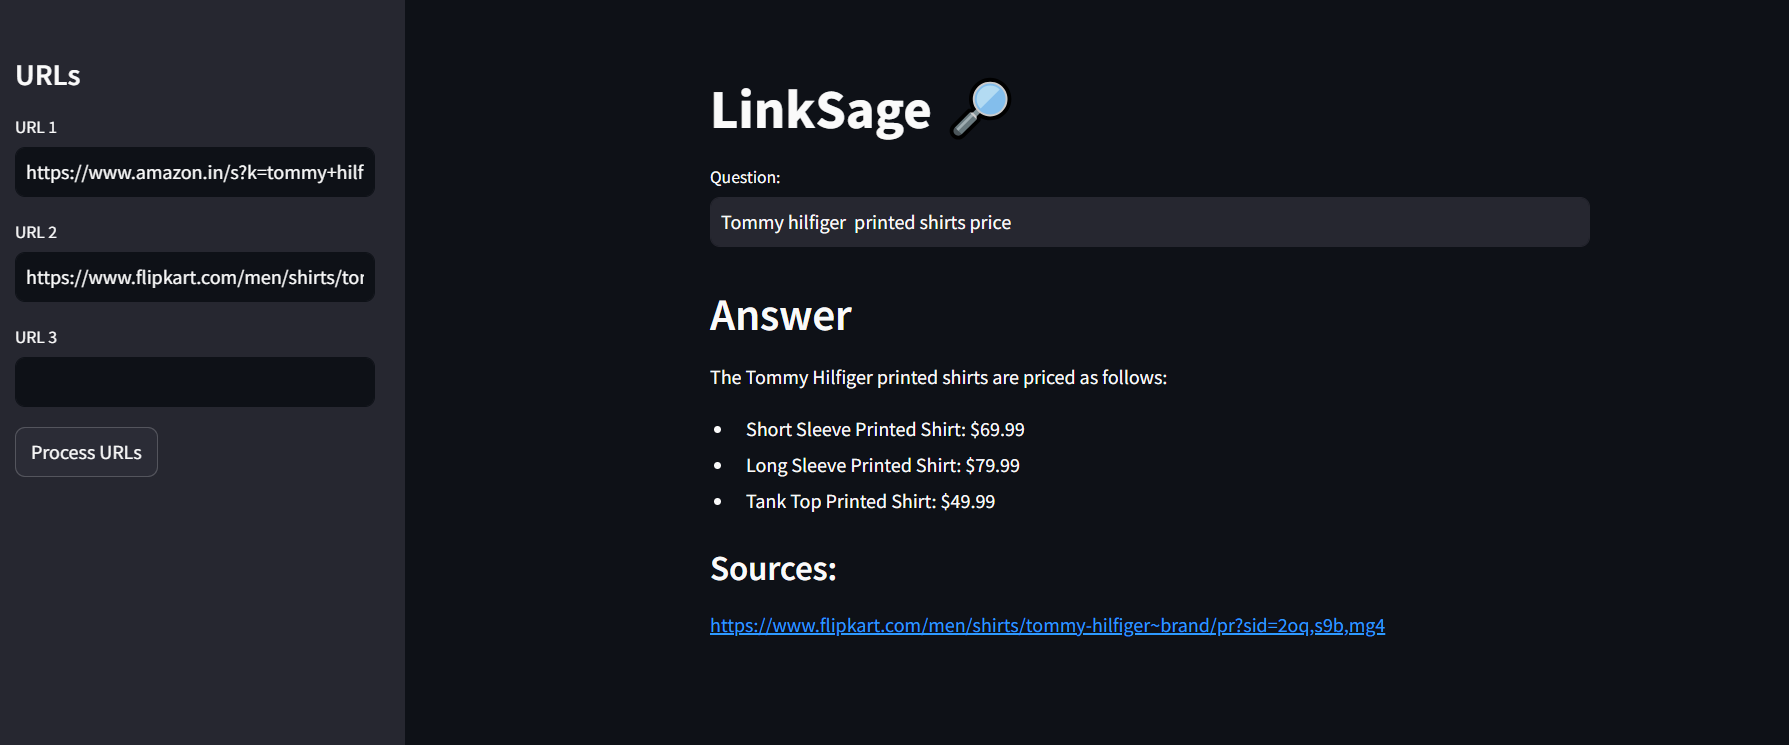

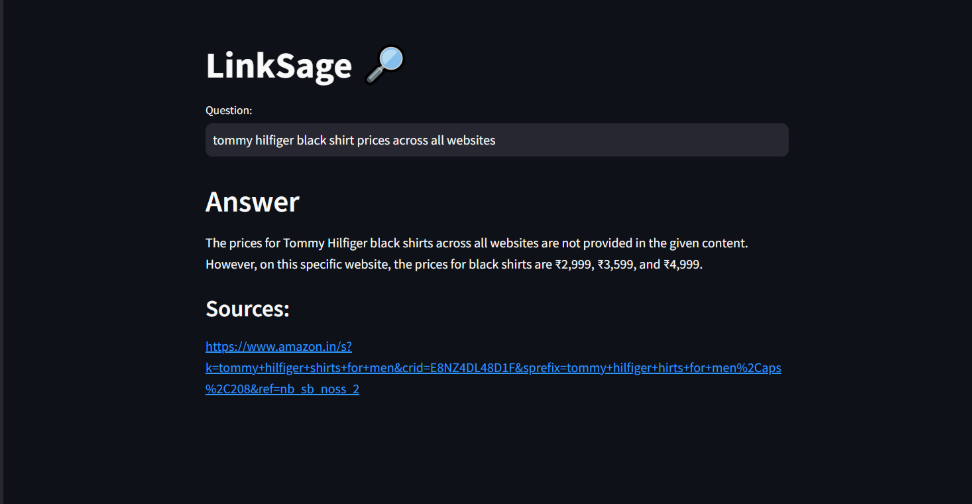

#Blog generation

In [ ]:
%%writefile blog-gen.py
import streamlit as st
from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers
import os
from langchain_huggingface.llms import HuggingFaceEndpoint

## Function To get response from LLAma 2 model

def getLLamaresponse(input_text,no_words,blog_style):

    ### LLama2 model
    repo_id = 'mistralai/Mistral-7B-Instruct-v0.3'

    os.environ["HUGGINGFACEHUB_API_TOKEN"] = 'hf_api'
    HUGGINGFACEHUB_API_TOKEN = 'hf_api'

    llm = HuggingFaceEndpoint(
        repo_id=repo_id, temperature=0.5, token=HUGGINGFACEHUB_API_TOKEN,
    )

    template="""
        Write a blog for {blog_style} job profile for a topic {input_text}
        within {no_words} words.
            """

    prompt=PromptTemplate(input_variables=["blog_style","input_text",'no_words'],
                          template=template)

    ## Generate the ressponse from the LLama 2 model
    response=llm(prompt.format(blog_style=blog_style,input_text=input_text,no_words=no_words))
    print(response)
    return response



st.set_page_config(page_title="Generate Blogs",
                    page_icon='🤖',
                    layout='centered',
                    initial_sidebar_state='collapsed')

st.header("Blogsmith 🤖")

input_text=st.text_input("Enter the Blog Topic")

## creating to more columns for additonal 2 fields

col1,col2=st.columns([5,5])

with col1:
    no_words=st.text_input('No of Words')
with col2:
    blog_style=st.selectbox('Writing the blog for',
                            ('Researchers','Data Scientist','Common People'),index=0)

submit=st.button("Generate")

## Final response
if submit:
    st.write(getLLamaresponse(input_text,no_words,blog_style))


In [ ]:
from pyngrok import ngrok

# Set authentication token if you haven't already done so
ngrok.set_auth_token('ng_key')

# Start Streamlit server on a specific port
!nohup streamlit run blog-gen.py --server.port 5011 &

# Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5011', proto='http', bind_tls=True)

# Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

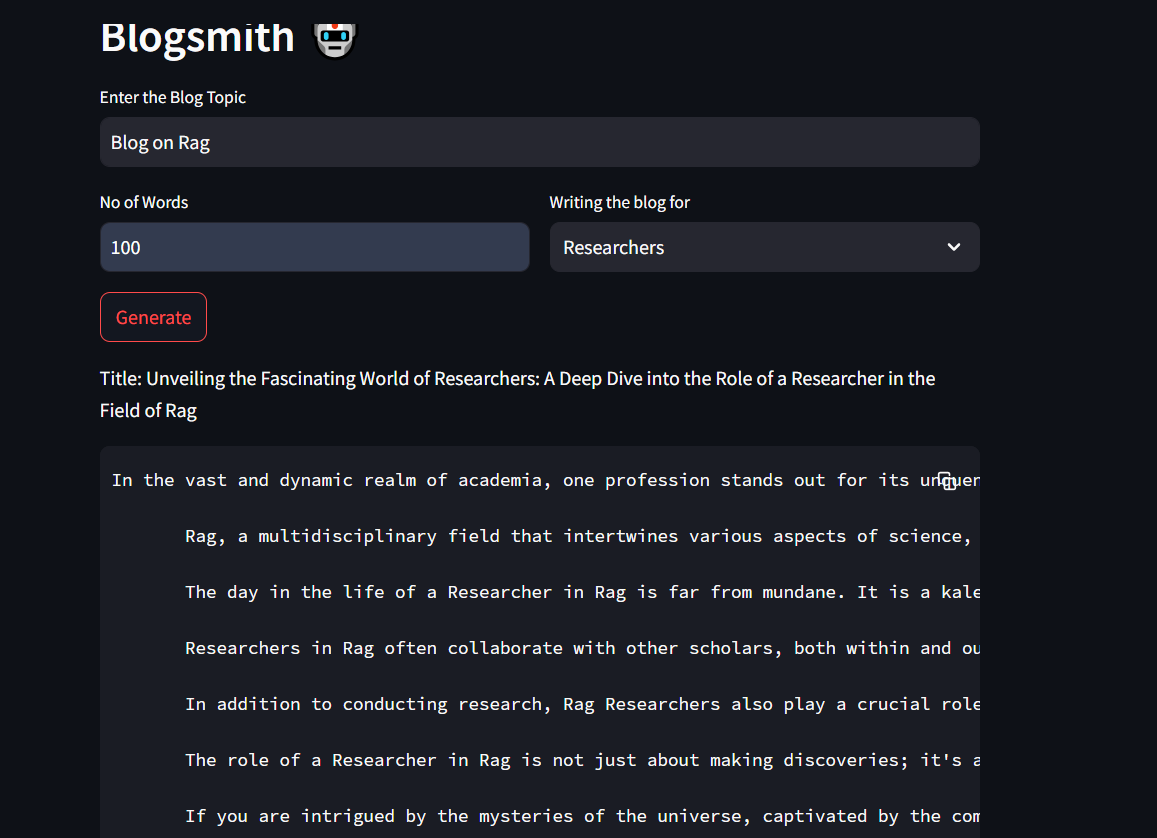

# Genoutfit

In [3]:
%%writefile st.py
import streamlit as st
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
from diffusers import DiffusionPipeline
import torch

def generate_image(prompt):

    pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    pipe.to("cuda")

    # if using torch < 2.0
    # pipe.enable_xformers_memory_efficient_attention()

    image = pipe(prompt=prompt).images[0]
    return image

def main():

    st.title('Generate Outfits using AI')

    text_input = st.text_input("Enter some text 👇")

    if st.button("Predict"):

        x=generate_image(text_input)

        st.image(x)

if __name__=='__main__':
    main()

Writing st.py


In [4]:
from pyngrok import ngrok

# Set authentication token if you haven't already done so
ngrok.set_auth_token('ng_key')

# Start Streamlit server on a specific port
!nohup streamlit run st.py --server.port 5011 &

# Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5011', proto='http', bind_tls=True)

# Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

nohup: appending output to 'nohup.out'
 * Tunnel URL: https://c95b-35-204-107-119.ngrok-free.app


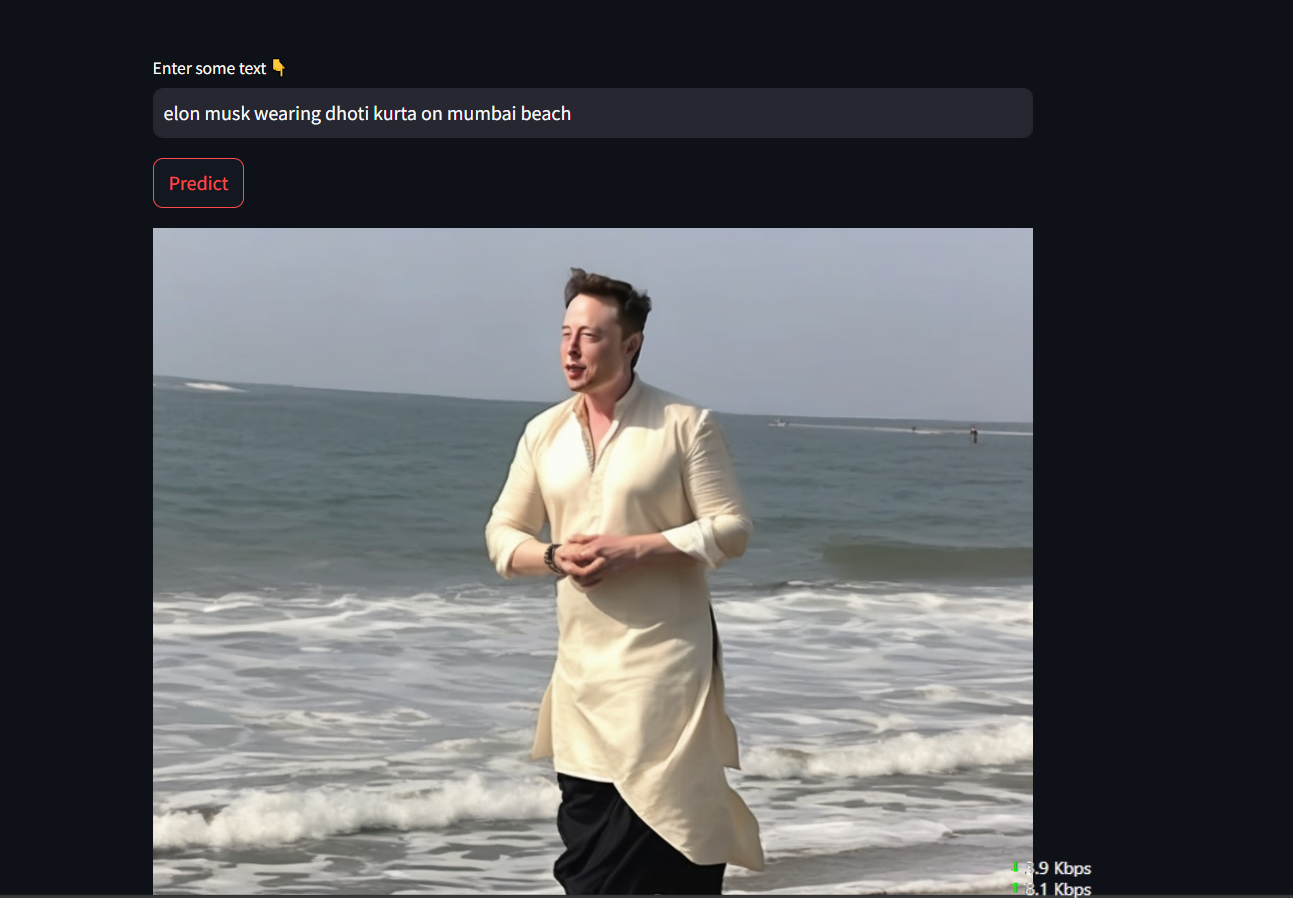

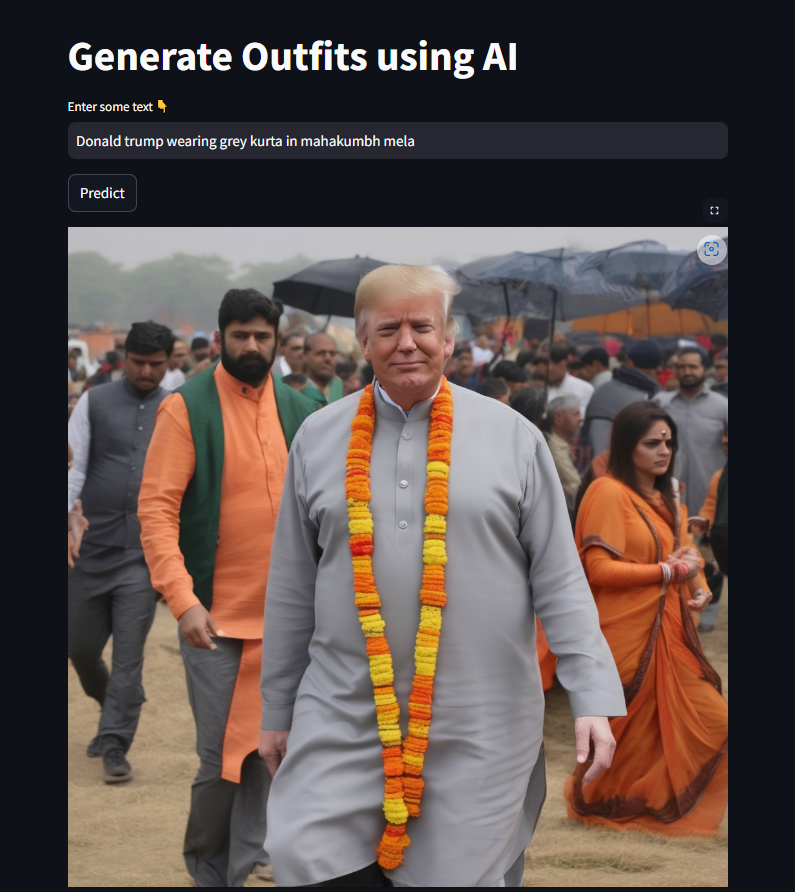